# SVM Model Training

## Import Common Libraries

In [ ]:
import numpy as np
from tqdm import tqdm

## Define paths

In [ ]:
svm_features_dir = "../data/features/audio_16k/mfcc+deltas_spectral_prosodic_computed_statistics/audio_features"
metadata_dir = "../data/features/audio_16k/mfcc+deltas_spectral_prosodic_computed_statistics/metadata.csv"
final_model_dir = "../models/svm/final"

## Ensure dir exist

In [ ]:
import os

os.makedirs(final_model_dir, exist_ok=True)

## Load Metadata

In [ ]:
import pandas as pd

df = pd.read_csv(metadata_dir)
print(f"Total samples: {len(df)}")

## Encode labels for SVM

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Prepare labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['emotion'])

num_classes = len(le.classes_)
inverse_map = {idx: cls for idx, cls in enumerate(le.classes_)}

print("Number of classes:", num_classes)
print(inverse_map)

## Train/test split

In [ ]:
from sklearn.model_selection import train_test_split

file_paths = df['file_path'].values

train_paths, test_paths, y_train, y_test = train_test_split(
    file_paths, y_encoded, 
    test_size=0.2, 
    stratify=y_encoded, 
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")

## Create Generators

In [ ]:
import sys
sys.path.append("../src")
import classes
from classes import SVMDataGenerator

batch_size = 32
train_gen = SVMDataGenerator(train_paths, y_train, batch_size=batch_size, shuffle=True)
test_gen = SVMDataGenerator(test_paths, y_test, batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_gen)}")
print(f"Test batches: {len(test_gen)}")

## Initialize Scaler and SGDClassifier (Incremental SVM)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
svm_model = SGDClassifier(
    loss='hinge',  # This gives us SVM behavior
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    verbose=1,
    n_jobs=-1, 
    learning_rate='optimal'
)

## Train SVM Model with Mini-Batches

In [ ]:
epochs = 10
print(f"\nTraining SVM model for {epochs} epochs...")

for epoch in range(epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{epochs}")
    print('='*60)
    
    train_gen.reset()
    
    for batch_idx in tqdm(range(len(train_gen)), desc=f"Epoch {epoch+1}"):
        X_batch, y_batch = train_gen.next_batch()
        
        # Fit or transform the scaler
        if epoch == 0 and batch_idx == 0:
            # First batch: fit the scaler
            X_batch_scaled = scaler.fit_transform(X_batch)
            # First fit for SGDClassifier (need to specify classes)
            svm_model.partial_fit(X_batch_scaled, y_batch, classes=np.arange(num_classes))
        else:
            # Transform using fitted scaler
            X_batch_scaled = scaler.transform(X_batch)
            # Continue training
            svm_model.partial_fit(X_batch_scaled, y_batch)

print("\n✓ Training complete!")

## Make Predictions

## Use generator to load test data in batche

In [ ]:
test_gen.reset()
y_pred_list = []

for batch_idx in tqdm(range(len(test_gen)), desc="Predicting"):
    X_batch, _ = test_gen.next_batch()
    X_batch_scaled = scaler.transform(X_batch)
    y_pred_batch = svm_model.predict(X_batch_scaled)
    y_pred_list.extend(y_pred_batch)

y_pred = np.array(y_pred_list)
print(f"Total predictions: {len(y_pred)}")

## Evaluate Model

### Accuracy, Precision, Recall, F1-score

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

### Confusion Matrix

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from plotnine import *

# Convert numeric labels → emotion names
true_labels = [inverse_map[i] for i in y_test]
pred_labels = [inverse_map[i] for i in y_pred]

# Compute confusion matrix
labels = sorted(list(inverse_map.values()))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Convert to tidy DataFrame for plotnine
df_cm = (
    pd.DataFrame(cm, index=labels, columns=labels)
      .reset_index()
      .melt(id_vars='index')
)

df_cm.columns = ['True', 'Predicted', 'Count']

# Plot confusion matrix
(
    ggplot(df_cm, aes('Predicted', 'True', fill='Count'))
    + geom_tile()
    + geom_text(aes(label='Count'), color='white', size=10)
    + scale_fill_gradient(low='#d0e1f9', high='#023e8a')
    + theme_minimal()
    + labs(title='Confusion Matrix', x='Predicted label', y='True label')
)

### Unweighted Average Recall (UAR)

In [ ]:
uar = recall_score(y_test, y_pred, average='macro')
print(f"Unweighted Average Recall (UAR): {uar:.4f}")

### Detailed classification report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

## Save Model

In [ ]:
import pickle

model_path = os.path.join(final_model_dir, "svm-ser-model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(svm_model, f)

## Save Scalar

In [ ]:
scaler_path = os.path.join(final_model_dir, "scaler.pkl")
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

## Label Encoder

In [ ]:
encoder_path = os.path.join(final_model_dir, "label_encoder.pkl")
with open(encoder_path, 'wb') as f:
    pickle.dump(le, f)

## Validate model with other dataset

### Initialize Class Predictor

In [2]:
import sys
import librosa
import numpy as np
import pickle

sys.path.append("..")
import utils
from utils import extract_mfcc_features
from utils import extract_prosodic_features
from utils import extract_spectral_features
from utils import compute_feature_statistics

sys.path.append("../src")
import classes
from classes import SVMAudioPredictor

def extract_audio_features(file_path):
    audio, sr = librosa.load(file_path, sr=16000)

    # Extract time-series features
    mfcc = extract_mfcc_features(audio, sr) # (120, time)
    spectral = extract_spectral_features(audio, sr) # (12, time)
    prosodic = extract_prosodic_features(audio, sr) # (2, time) 

    # Align all features to same length
    min_len = min(mfcc.shape[1], spectral.shape[1], prosodic.shape[1])
    mfcc = mfcc[:, :min_len]
    spectral = spectral[:, :min_len]
    prosodic = prosodic[:, :min_len]

    # Stack all features
    all_features = np.vstack([mfcc, spectral, prosodic])  # (134, time_frames)

    # Compute statistics
    feature_vector = compute_feature_statistics(all_features)

    return feature_vector

with open('../models/svm/final/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

predictor = SVMAudioPredictor(
    model_path='../models/svm/final/svm-ser-model.pkl',
    scaler_path='../models/svm/final/scaler.pkl',
    feature_extractor=extract_audio_features,
    label_encoder=label_encoder 
)

✓ Scaler loaded from ../models/svm/final/scaler.pkl
  Feature dimensions: 931
✓ Model loaded with 6 classes
  Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


### Emovo Dataset

#### Get Predictions

Extracting features...
Processing batch 1/16
  Feature dimension: (931,)
Processing batch 2/16
Processing batch 3/16
Processing batch 4/16
Processing batch 5/16
Processing batch 6/16
Processing batch 7/16
Processing batch 8/16
Processing batch 9/16
Processing batch 10/16
Processing batch 11/16
Processing batch 12/16
Processing batch 13/16
Processing batch 14/16
Processing batch 15/16
Processing batch 16/16
Scaling features...
  Scaled feature range: [-27.125, 38.259]
Making predictions...

Prediction distribution:
  angry: 115 (22.8%)
  disgust: 85 (16.9%)
  fear: 216 (42.9%)
  happy: 38 (7.5%)
  neutral: 10 (2.0%)
  sad: 40 (7.9%)

OVERALL METRICS
Accuracy:  0.2619 (26.19%)
Precision: 0.2999
Recall:    0.2619
F1 Score:  0.2301

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.22      0.30      0.25        84
     disgust       0.22      0.23      0.22        84
        fear       0.26      0.68      0.38        84
       happy

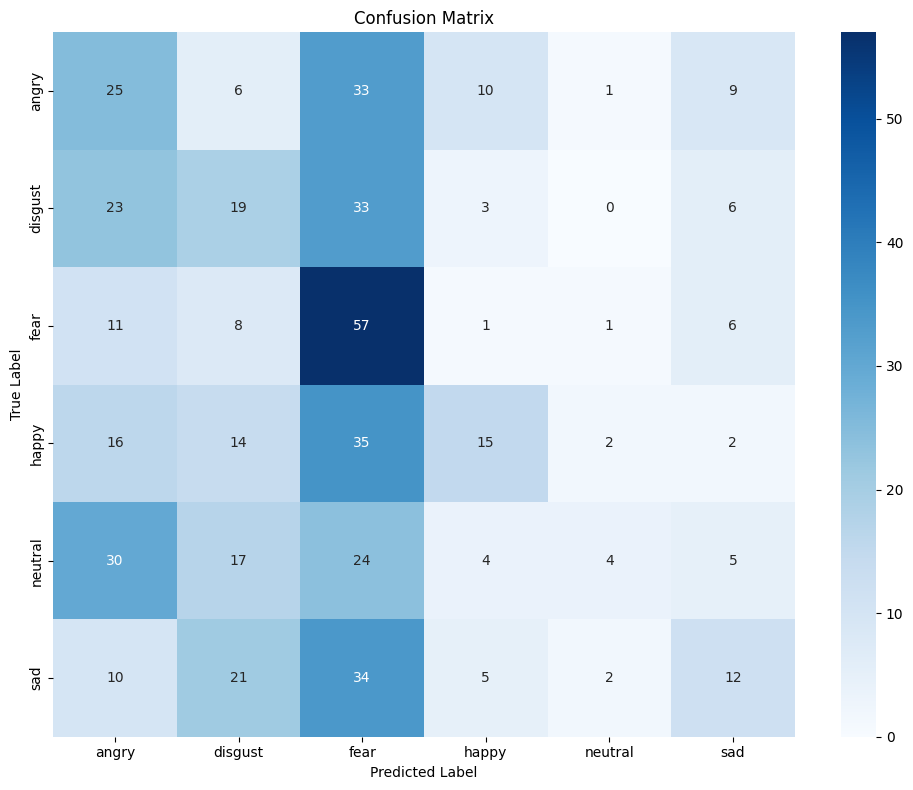

In [3]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/emovo/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)

### Subesco Dataset

#### Get Predictions

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Total samples: 500
Emotion distribution:
emotion
angry      85
disgust    83
fear       83
happy      83
neutral    83
sad        83
Name: count, dtype: int64
Extracting features...
Processing batch 1/16


/tmp/ipykernel_16211/4039418328.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


  Feature dimension: (931,)
Processing batch 2/16
Processing batch 3/16
Processing batch 4/16
Processing batch 5/16
Processing batch 6/16
Processing batch 7/16
Processing batch 8/16
Processing batch 9/16
Processing batch 10/16
Processing batch 11/16
Processing batch 12/16
Processing batch 13/16
Processing batch 14/16
Processing batch 15/16
Processing batch 16/16
Scaling features...
  Scaled feature range: [-52.993, 119.883]
Making predictions...

Prediction distribution:
  angry: 381 (76.2%)
  disgust: 1 (0.2%)
  fear: 83 (16.6%)
  happy: 34 (6.8%)
  sad: 1 (0.2%)

OVERALL METRICS
Accuracy:  0.1920 (19.20%)
Precision: 0.2903
Recall:    0.1898
F1 Score:  0.1225

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.17      0.74      0.27        85
     disgust       0.00      0.00      0.00        83
        fear       0.25      0.25      0.25        83
       happy       0.32      0.13      0.19        83
     neutral       0.00    

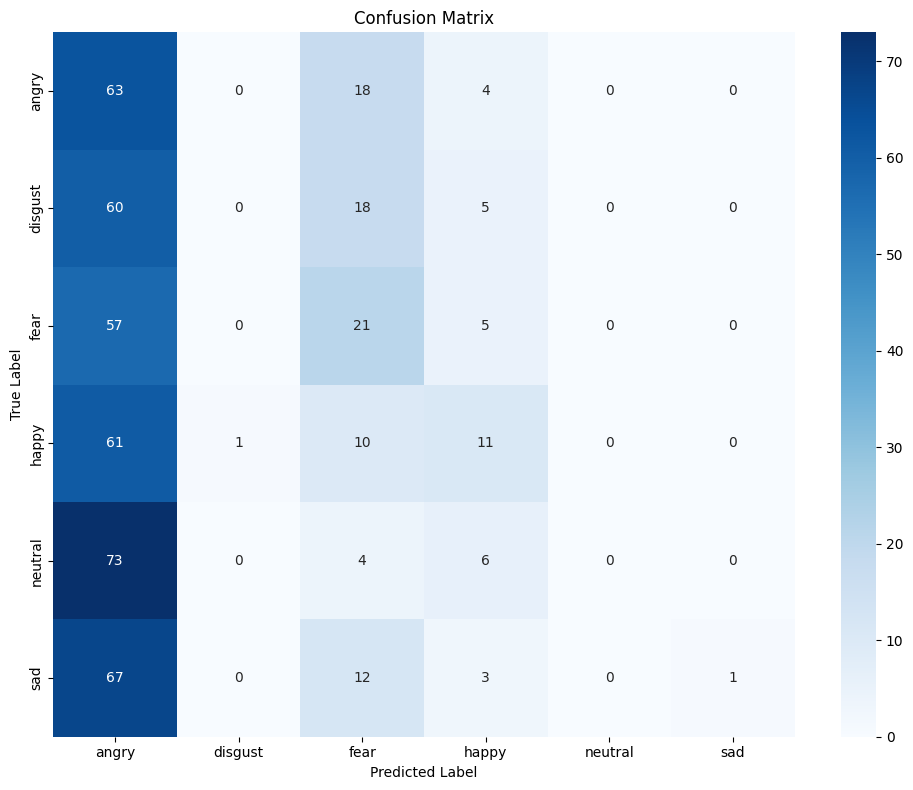

In [4]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/subesco/metadata.csv')

# Sample 500 rows with stratified sampling to maintain emotion distribution
max_samples = 500
samples_per_emotion = max_samples // df['emotion'].nunique()

# Stratified sampling
df_sampled = df.groupby('emotion', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per_emotion), random_state=42)
)

# If we don't have exactly 500, fill up to 500 with remaining samples
if len(df_sampled) < max_samples:
    remaining = max_samples - len(df_sampled)
    remaining_df = df[~df.index.isin(df_sampled.index)].sample(n=remaining, random_state=42)
    df_sampled = pd.concat([df_sampled, remaining_df])

file_paths = df_sampled["file_path"].tolist()
labels_dict = dict(zip(df_sampled['file_path'], df_sampled['emotion']))
true_labels = df_sampled["emotion"].tolist()

# Print distribution to verify
print(f"Total samples: {len(df_sampled)}")
print(f"Emotion distribution:\n{df_sampled['emotion'].value_counts().sort_index()}")

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)

### Gathered Dataset

#### Get Predictions

Extracting features...
Processing batch 1/2
  Feature dimension: (931,)
Processing batch 2/2
Scaling features...
  Scaled feature range: [-39.767, 44.786]
Making predictions...

Prediction distribution:
  angry: 28 (46.7%)
  disgust: 18 (30.0%)
  fear: 8 (13.3%)
  happy: 4 (6.7%)
  sad: 2 (3.3%)

OVERALL METRICS
Accuracy:  0.1667 (16.67%)
Precision: 0.1233
Recall:    0.1667
F1 Score:  0.1250

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.14      0.40      0.21        10
     disgust       0.22      0.40      0.29        10
        fear       0.12      0.10      0.11        10
       happy       0.25      0.10      0.14        10
     neutral       0.00      0.00      0.00        10
         sad       0.00      0.00      0.00        10

    accuracy                           0.17        60
   macro avg       0.12      0.17      0.13        60
weighted avg       0.12      0.17      0.13        60



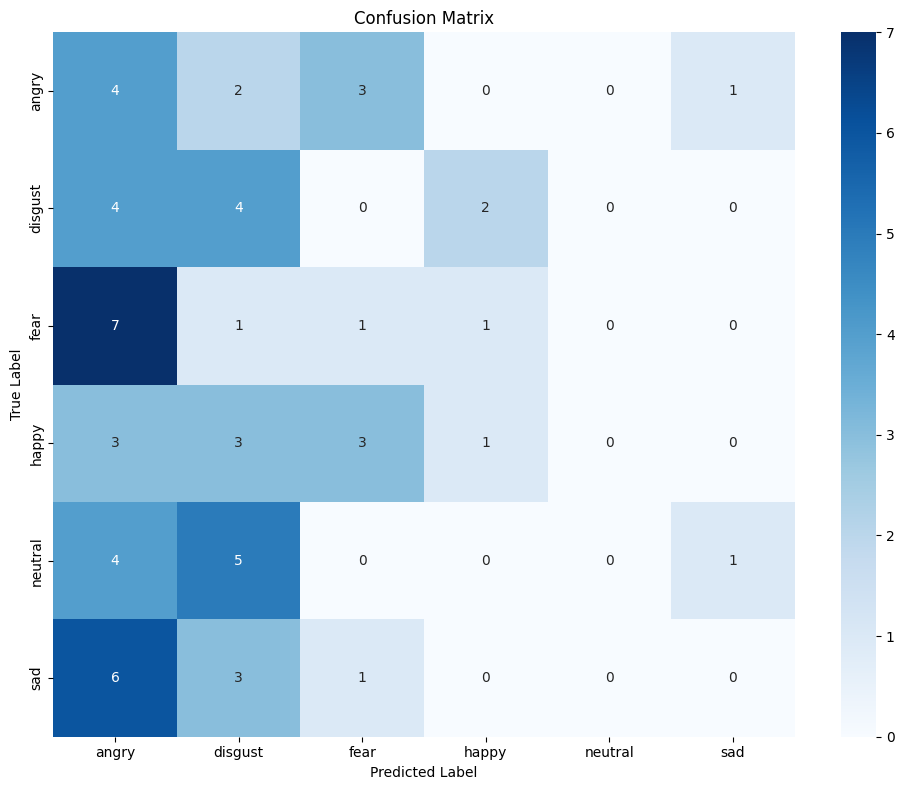

In [5]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/gathered/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)

### Emodb Dataset

#### Get Predictions

Extracting features...
Processing batch 1/15
  Feature dimension: (931,)
Processing batch 2/15
Processing batch 3/15
Processing batch 4/15
Processing batch 5/15
Processing batch 6/15
Processing batch 7/15
Processing batch 8/15
Processing batch 9/15
Processing batch 10/15
Processing batch 11/15
Processing batch 12/15
Processing batch 13/15
Processing batch 14/15
Processing batch 15/15
Scaling features...
  Scaled feature range: [-38.584, 72.956]
Making predictions...

Prediction distribution:
  angry: 303 (66.7%)
  disgust: 14 (3.1%)
  fear: 103 (22.7%)
  happy: 29 (6.4%)
  neutral: 2 (0.4%)
  sad: 3 (0.7%)

OVERALL METRICS
Accuracy:  0.3194 (31.94%)
Precision: 0.3902
Recall:    0.2468
F1 Score:  0.2048

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.32      0.77      0.46       127
     disgust       0.36      0.11      0.17        46
        fear       0.28      0.42      0.34        69
       happy       0.38      0.15     

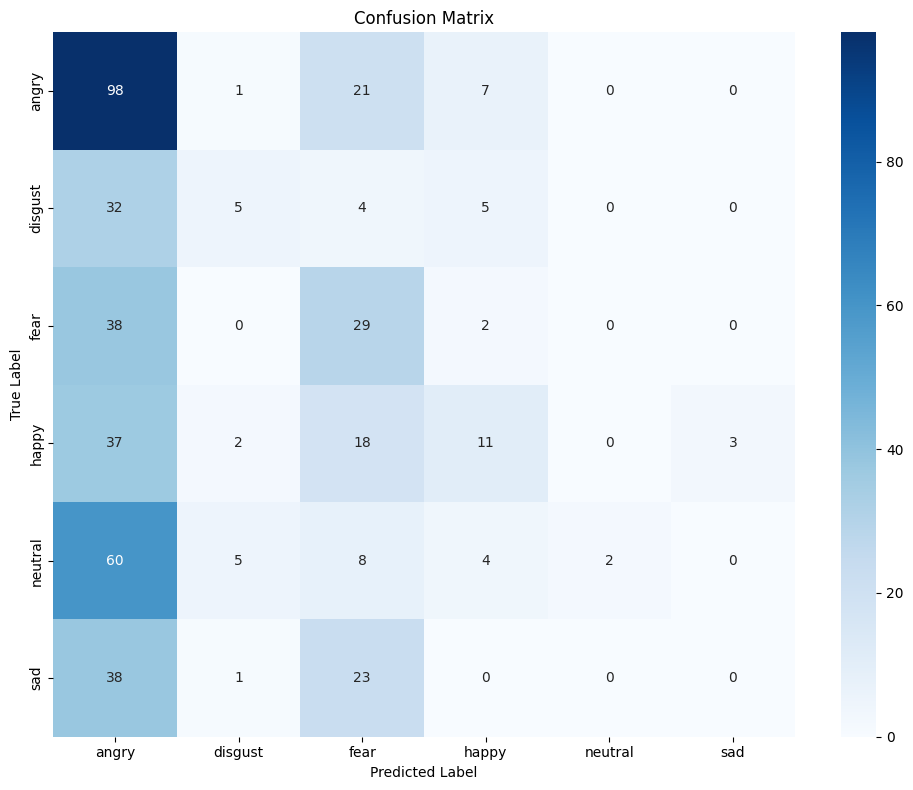

In [6]:
import pandas as pd

df = pd.read_csv('../data/processed/audio_16k/emodb/metadata.csv')
file_paths = df["file_path"].tolist()

labels_dict = dict(zip(df['file_path'], df['emotion']))

true_labels = df["emotion"].tolist()

results, metrics = predictor.evaluate(
    file_paths=file_paths,
    true_labels=true_labels,
    batch_size=32,
    plot_cm=True,  # Generate visual confusion matrix
)